In [4]:
import sys
from os.path import join
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy import sqrt
import numpy as np
from datetime import datetime, timedelta

from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

/Users/in45816805/Library/CloudStorage/OneDrive-Tesco/Scripts/AWSMLHack/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [5]:
import pandas as pd

train_data = pd.read_csv('dataset/train.csv')
train_data.head()

,ID,Datetime,City_ID,Particulate_matter,SO2_concentration,O3_concentration,CO_concentration,NO2_concentration,Presure,Dew_point,Precipitation,Anonymous_X1,Wind_speed,Moisture_percent,Temperature
0,0,01/01/17 14:00,0,14.0,40.12,85,600.14,38.55,1024.5,-21.4,0.0,1.15,5.7,62.84,-0.323
1,1,01/01/17 15:00,0,12.0,65.59,84,2082.38,96.09,1025.1,-22.1,0.0,2.24,3.9,79.45,-0.570
2,2,01/01/17 16:00,0,6.0,58.87,83,1475.88,111.09,1025.3,-24.6,0.0,45.70,5.3,83.44,-1.008
3,3,01/01/17 17:00,0,5.0,84.67,84,2448.53,67.59,1026.2,-25.5,0.0,15.90,4.9,81.27,-1.234
4,4,01/01/17 18:00,0,5.0,83.66,77,2224.61,95.86,1027.1,-24.5,0.0,31.30,3.2,81.93,-1.704


In [6]:
train_data.shape

(56000, 15)

In [7]:
city0_ids = train_data[train_data['City_ID'] == 0]
city1_ids = train_data[train_data['City_ID'] == 1]
city1_ids = city1_ids.reset_index()
print(city1_ids['ID'], city0_ids['ID'])

0        35044
1        35045
2        35046
3        35047
4        35048
         ...  
27995    63039
27996    63040
27997    63041
27998    63042
27999    63043
Name: ID, Length: 28000, dtype: int64 0            0
1            1
2            2
3            3
4            4
         ...  
27995    27995
27996    27996
27997    27997
27998    27998
27999    27999
Name: ID, Length: 28000, dtype: int64


In [8]:
train2d_c0 = train_data[train_data['City_ID'] == 0].drop(columns=['City_ID', 'ID']).to_numpy()
train2d_c1 = train_data[train_data['City_ID'] == 1].drop(columns=['City_ID', 'ID']).to_numpy()
dates = train_data[['Datetime']].to_numpy()
headers = train_data.drop(columns=['City_ID', 'ID', 'Datetime']).columns

print(train2d_c0.shape)
print(train2d_c1.shape)
print(headers)




(28000, 13)
(28000, 13)
Index(['Particulate_matter', 'SO2_concentration', 'O3_concentration',
       'CO_concentration', 'NO2_concentration', 'Presure', 'Dew_point',
       'Precipitation', 'Anonymous_X1', 'Wind_speed', 'Moisture_percent',
       'Temperature'],
      dtype='object')


In [9]:
dates

array([['01/01/17 14:00'],
       ['01/01/17 15:00'],
       ['01/01/17 16:00'],
       ...,
       ['13/03/20 05:00'],
       ['13/03/20 06:00'],
       ['13/03/20 07:00']], dtype=object)

In [10]:
from datetime import datetime, timedelta

# Define the start and end of the datetime range
start_d = datetime.strptime("01/01/17 14:00", "%d/%m/%y %H:%M")
end_d = datetime.strptime("13/03/20 07:00", "%d/%m/%y %H:%M")

# print(end_d - start_d)

correct_dates = []

current_d = start_d
while current_d<=end_d:
    correct_dates.append(current_d.strftime("%d/%m/%y %H:%M"))
    current_d += timedelta(hours=1)

correct_dates_np  = np.array(correct_dates)
print(len(correct_dates_np), correct_dates_np[-1], correct_dates_np)

28002 13/03/20 07:00 ['01/01/17 14:00' '01/01/17 15:00' '01/01/17 16:00' ... '13/03/20 05:00'
 '13/03/20 06:00' '13/03/20 07:00']


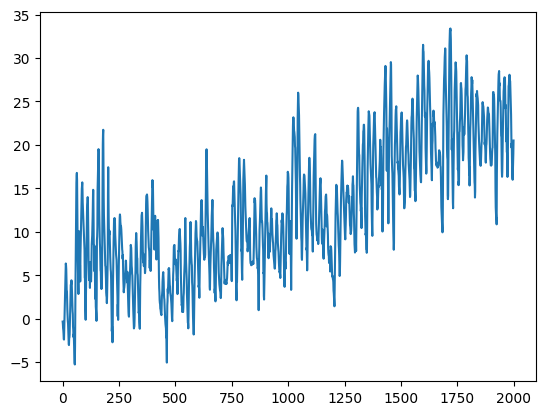

In [11]:
temp1 = train2d_c1[:2000, 12]
plt.plot(range(len(temp1)), temp1)

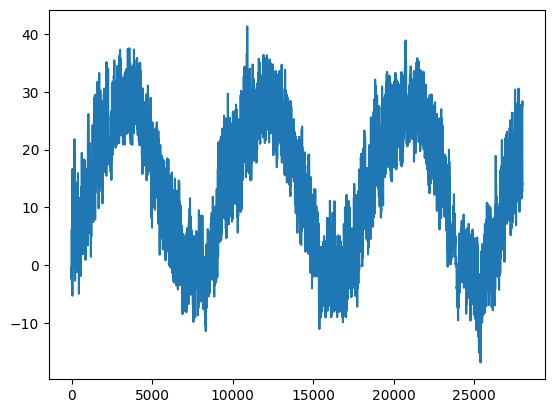

In [12]:
temp0 = train2d_c0[:, 12] 
plt.plot(range(len(temp0)), temp0)

In [13]:
def fill_missing_dates(data):
   
    data_dt = np.array([
        datetime.strptime(x, '%d/%m/%y %H:%M') if '/' in x else None
        for x in data
    ])
    
    
    for i in range(1, len(data_dt) - 1):
        if data_dt[i] is None:
            
            prev = next((data_dt[j] for j in range(i - 1, -1, -1) if data_dt[j] is not None), None)
            next_ = next((data_dt[j] for j in range(i + 1, len(data_dt)) if data_dt[j] is not None), None)
            
            
            if prev and next_:
                
                diff = (next_ - prev) / 2
                data_dt[i] = prev + diff
            elif prev:
                data_dt[i] = prev + timedelta(hours=1)  
            elif next_:
                data_dt[i] = next_ - timedelta(hours=1)  
    
    # Convert datetime objects back to strings
    data_filled = np.array([dt.strftime('%d/%m/%y %H:%M') if dt else 'N/A' for dt in data_dt])
    
    return data_filled


In [14]:
train2d_c0[:, 0] = fill_missing_dates(train2d_c0[:, 0])
train2d_c1[:, 0] = fill_missing_dates(train2d_c1[:, 0])

print(train2d_c0[:2, :])

[['01/01/17 14:00' 14.0 '40.12' '85' '600.14' 38.55 1024.5 -21.4 0.0 1.15
  5.7 62.84 -0.323]
 ['01/01/17 15:00' 12.0 '65.59' '84' '2082.38' 96.09 1025.1 -22.1 0.0
  2.24 3.9 79.45 -0.57]]


In [15]:
unique_values = np.unique(train2d_c0[:, 0])
unique_values.sort()
print(unique_values[-1], unique_values[0])

31/12/19 23:00 01/01/17 14:00


In [16]:
def replace_non_numerical_with_nan(arr1):
    # Create an empty array of the same shape
    result = np.empty(arr1.shape, dtype=float)
    for i in range(arr1.shape[0]):
        for j in range(arr1.shape[1]):
            try:
                # Try converting to float
                result[i, j] = float(arr1[i, j])
            except ValueError:
                # Replace with NaN if conversion fails
                result[i, j] = np.nan
    return result

In [17]:
train2d_c0[:,1:] = replace_non_numerical_with_nan(train2d_c0[:,1:])
train2d_c1[:,1:] = replace_non_numerical_with_nan(train2d_c1[:,1:])
print(unique_values[-1], unique_values[0])
print(train2d_c0[:2, :])

31/12/19 23:00 01/01/17 14:00
[['01/01/17 14:00' 14.0 40.12 85.0 600.14 38.55 1024.5 -21.4 0.0 1.15 5.7
  62.84 -0.323]
 ['01/01/17 15:00' 12.0 65.59 84.0 2082.38 96.09 1025.1 -22.1 0.0 2.24
  3.9 79.45 -0.57]]


In [18]:
def fill_nan_with_neighbors_mean(arr):
    # Iterate over each column to fill NaNs
    for col in range(arr.shape[1]):
        for row in range(arr.shape[0]):
            if np.isnan(arr[row, col]):
                # Check values above and below, handling boundaries
                above = arr[row - 1, col] if row - 1 >= 0 else np.nan
                below = arr[row + 1, col] if row + 1 < arr.shape[0] else np.nan
                
                # Calculate mean of available neighbors
                non_nan_neighbors = [x for x in [above, below] if not np.isnan(x)]
                if non_nan_neighbors:
                    arr[row, col] = np.mean(non_nan_neighbors)

    return arr


In [19]:
train2d_c0[:,1:] = fill_nan_with_neighbors_mean(train2d_c0[:,1:])
train2d_c1[:,1:] = fill_nan_with_neighbors_mean(train2d_c1[:,1:])
print(train2d_c0[:2, :])

[['01/01/17 14:00' 14.0 40.12 85.0 600.14 38.55 1024.5 -21.4 0.0 1.15 5.7
  62.84 -0.323]
 ['01/01/17 15:00' 12.0 65.59 84.0 2082.38 96.09 1025.1 -22.1 0.0 2.24
  3.9 79.45 -0.57]]


In [20]:
import numpy as np
import pandas as pd

def convert_datetimes_to_hours(datetime_array, datetime_format="%d/%m/%y %H:%M"):
    datetime_array = pd.to_datetime(datetime_array, format=datetime_format)

    start_datetime = datetime_array[0]

    int_array = np.array([(dt - start_datetime).total_seconds() / 3600 for dt in datetime_array], dtype=float)

    return int_array

int_array_c0 = convert_datetimes_to_hours(train2d_c0[:,0])
int_array_c1 = convert_datetimes_to_hours(train2d_c1[:,0])
print(int_array_c0, int_array_c0[-1], "\n",int_array_c1, int_array_c1[-1])
train2d_c0[:,0] = int_array_c0
train2d_c1[:,0] = int_array_c1
print(train2d_c0[:,0], train2d_c0[-1,0], "\n",train2d_c1[:,0], train2d_c1[-1,0])


[0.0000e+00 1.0000e+00 2.0000e+00 ... 2.7999e+04 2.8000e+04 2.8001e+04] 28001.0 
 [0.0000e+00 1.0000e+00 2.0000e+00 ... 2.7999e+04 2.8000e+04 2.8001e+04] 28001.0
[0.0 1.0 2.0 ... 27999.0 28000.0 28001.0] 28001.0 
 [0.0 1.0 2.0 ... 27999.0 28000.0 28001.0] 28001.0


In [21]:
print(train2d_c0[:1,:], type(train2d_c0[0,0]))
datetimes_c0 = train2d_c0[:,0]/28001
datetimes_c1 = train2d_c1[:,0]/28001
train_c0 = train2d_c0[:,1:].astype(float)
train_c1 = train2d_c1[:,1:].astype(float)
train_c0[:1, :]

[[0.0 14.0 40.12 85.0 600.14 38.55 1024.5 -21.4 0.0 1.15 5.7 62.84 -0.323]] <class 'float'>


array([[ 1.4000e+01,  4.0120e+01,  8.5000e+01,  6.0014e+02,  3.8550e+01,
         1.0245e+03, -2.1400e+01,  0.0000e+00,  1.1500e+00,  5.7000e+00,
         6.2840e+01, -3.2300e-01]])

In [22]:
train_c0 = train_c0.astype(float)
train_c1 = train_c1.astype(float)

mean = train_c0.mean(axis=0)
train_c0 -= mean
std = train_c0.std(axis=0)
train_c0 /= std
np.save('mean_values_c0.npy', mean)
np.save('std_values_c0.npy', std)

mean = train_c1.mean(axis=0)
train_c1 -= mean
std = train_c1.std(axis=0)
train_c1 /= std
np.save('mean_values_c1.npy', mean)
np.save('std_values_c1.npy', std)

In [23]:
nan_count_per_column = np.isnan(train_c0).sum(axis=0)
print(nan_count_per_column)

[0 0 0 0 0 0 0 0 0 0 0 0]


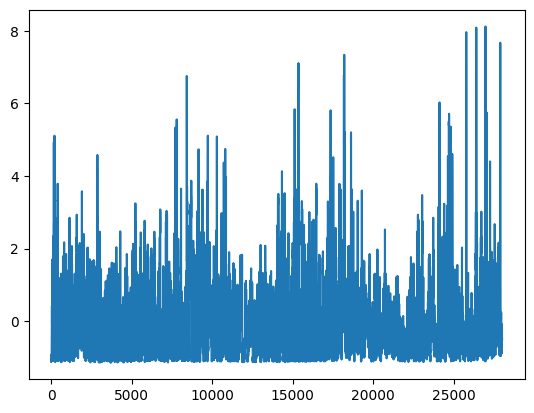

In [39]:
temp1 = train_c1[:, 0]
plt.plot(range(len(temp1)), temp1)

In [25]:
print(headers)

Index(['Particulate_matter', 'SO2_concentration', 'O3_concentration',
       'CO_concentration', 'NO2_concentration', 'Presure', 'Dew_point',
       'Precipitation', 'Anonymous_X1', 'Wind_speed', 'Moisture_percent',
       'Temperature'],
      dtype='object')


In [26]:
print(datetimes_c0)
df_c0 = pd.DataFrame(train_c0, columns=headers)
df_c0_datetime = pd.DataFrame(datetimes_c0, columns=['Datetime'])
df_c0['Datetime'] = df_c0_datetime['Datetime']
df_c0['ID'] = city0_ids['ID']
df_c0.head()
df_c0.to_csv('dataset/train_clean_c0.csv', index=False)

[0.0 3.571301024963394e-05 7.142602049926788e-05 ... 0.9999285739795007
 0.9999642869897504 1.0]


In [27]:
print(datetimes_c1)
df_c1 = pd.DataFrame(train_c1, columns=headers)
df_c1_datetime = pd.DataFrame(datetimes_c1, columns=['Datetime'])
df_c1['Datetime'] = df_c1_datetime['Datetime']
df_c1['ID'] = city1_ids['ID']
df_c1.head()
df_c0.to_csv('dataset/train_clean_c1.csv', index=False)


[0.0 3.571301024963394e-05 7.142602049926788e-05 ... 0.9999285739795007
 0.9999642869897504 1.0]
